In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

In [2]:
print('torch version:',torch.__version__)

torch version: 2.4.1+cu124


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('device:', device)
else:
    device = torch.device("cpu")
    print('CUDA is not available. Using CPU.')

device: cuda


The system:

\begin{align}
\partial_r A &= A \left[ \frac{(1-A)}{r} + 8 \pi r A \rho \right] \; ,
 \\
\partial_r \alpha &= \alpha \left[ \frac{(A-1)}{2r} + 8 \pi r A S_A \right] \; ,
 \\
\partial_r \chi &= - \frac{\chi}{r} \left[ 1+A - 8 \pi r A V(\phi) \right]
+ A \left[ \rule{0mm}{5mm} \frac{dV}{d\phi}
- \left( \frac{\omega}{\alpha} \right)^2 \phi \right]  \; ,
 \\
\partial_r \phi &= \chi
 \; ,
\end{align}

Boundary conditions:
\begin{align}
A(r=0) = 1 \,, \quad \partial_r \alpha(r=0) = 0 \,, \quad \phi(r=0) = \phi_0 \,, \quad \chi(r=0) = 0 \,,
\\
A(r \rightarrow \infty) = 1 \,, \quad \alpha(r \rightarrow \infty) = 1 \,, \quad \phi(r \rightarrow \infty) = 0 \,, \quad \chi(r \rightarrow \infty) = 0 \,.
\end{align}

The potential is
$$
V(\phi) = \frac{1}{2} m^2 \phi^2 \,, \quad \frac{d V}{d \phi} = m^2 \phi \,.
$$

To start, let's try to get a solution for fixed $\omega$ and $\phi_0$ (known solutions from Miguel Bezares).

In [4]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [5]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [6]:
# random (uniform) sample points in (0,1).
def random_domain_points(n):
    #x = torch.rand((n,1), requires_grad=True)
    xhigh = 0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # [0.5,1)
    xlow  = -0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # (0,0.5]
    x = torch.cat((xlow, xhigh),0)
    return x

In [70]:
def domain_loss(u, r, omega, m): 
    A, alpha, chi, phi = map(lambda i:  u[:,[i]], range(4))
    # take derivatives
    Ar = gradients(A, r)
    alphar = gradients(alpha, r)
    chir = gradients(chi, r)
    phir = gradients(phi, r)
    
    omega = omega.to(device)
    
    # potential
    V = 0.5*torch.pow(m,2)*torch.pow(phi,2)
    # potential derivative wrt phi
    dVdphi = torch.pow(m,2)*phi
    # rho
    rho = 0.5*(torch.pow(chi,2)/A + torch.pow((omega/alpha),2)*torch.pow(phi,2)) + V
    # S_A
    SA = 0.5*(torch.pow(chi,2)/A + torch.pow((omega/alpha),2)*torch.pow(phi,2)) - V
    # eq_A is \p_rA - rhs[A]
    eq_A = r*Ar - A*( (1-A) + 8*torch.pi*(r**2)*A*rho)
    # eq_alpha is \p_r alpha - rhs[alpha]
    eq_alpha = r*alphar - alpha*( 0.5*(A-1) + 8*torch.pi*A*(r**2)*SA)
    # eq_chi  is \p_r chi - rhs[chi]
    eq_chi = r*chir + (chi)*(1 + A - 8*torch.pi*r*A*V) - r*A*(dVdphi - torch.pow((omega/alpha),2)*phi)
    # eq_phi is \p_r phi - rhs[phi]
    eq_phi = phir - chi

    loss_dom = (torch.mean(torch.pow(eq_A,2)) + torch.mean(torch.pow(eq_alpha,2))
                + torch.mean(torch.pow(eq_chi,2)) + torch.mean(torch.pow(eq_phi,2)) 
               )
               
    return loss_dom

def r0_loss(u0, r0, phi0):    
    A, alpha, chi, phi = map(lambda i:  u0[[i]], range(4))
    # take derivatives
    alphar = gradients(alpha, r0)
    
    loss_r0 = torch.mean(torch.pow(A-1,2)) + torch.mean(torch.pow(alphar,2)) + torch.mean(torch.pow(phi-phi0,2)) + torch.mean(torch.pow(chi,2))
    return loss_r0

def rmax_loss(umax):
    A, alpha, chi, phi = map(lambda i:  umax[[i]], range(4))
    
    loss_rmax = torch.mean(torch.pow(A-1,2)) + torch.mean(torch.pow(alpha-1,2)) + torch.mean(torch.pow(phi,2)) + torch.mean(torch.pow(chi,2))
    return loss_rmax

# penalize the loss when A, alpha, or phi is negative
def negative_penalty(u):
    A, alpha, chi, phi = map(lambda i:  u[:,[i]], range(4))
    m = torch.nn.ReLU()
    penalty = (
        torch.mean(torch.pow(m(-A),2)) 
        + torch.mean(torch.pow(m(-alpha),2)) 
        + torch.mean(torch.pow(m(-phi),2))
    )
    return penalty

# for chi we penalize if it is positive (this implies that phi is a monotonically decreasing function)
def chi_positive_penalty(u):
    A, alpha, chi, phi = map(lambda i:  u[:,[i]], range(4))
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(chi),2))
    return penalty

# we set \partial_r \alpha |r=0, but not alpha.
# we want alpha >=0, otherwise, there will be a zero crossing in the bulk of the domain, which is a problem (1/alpha term)
def alpha_negative_penalty_r0(u): # at r0
    A, alpha, chi, phi = map(lambda i:  u[[i]], range(4))
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(-alpha),2))
    return penalty

# impose that phi is a monotonically decreasing function
def phi_monotonic_decrease_dom(u):
    A, alpha, chi, phi = map(lambda i:  u[:,[i]], range(4))
    phir = gradients(phi, r)
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(phir),2))
    return penalty

# impose that alpha is a monotonically increasing function
def alpha_monotonic_increase_dom(u):
    A, alpha, chi, phi = map(lambda i:  u[:,[i]], range(4))
    alphar = gradients(alpha, r)
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(-alphar),2))
    return penalty


In [73]:
#torch.manual_seed(123)

# input 1 (x), output 4 (A, alpha, phi, chi), 32 nodes per layer, 3 hidden layers
model = FCN(1,4,64,6).to(device)

# FCN(1,4,64,6).to(device) # did good 10^-2-10^-3 loss (decreasing trend, but much oscillation)

# true omega = 1.03859806273248977959156036376953125
#omega = torch.nn.Parameter(1.04*torch.ones(1, requires_grad=True))

#optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=1e-4)
omega = torch.nn.Parameter(1.03859*torch.ones(1))
optimizer = torch.optim.Adam(list(model.parameters()),lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# true also below
#scheduler = StepLR(optimizer, step_size=2000, gamma=1., verbose=False) 

In [74]:
n = 1000 # number of random sampling points

epochs = 20000
gamma1 = 1000.0 # BC r0
gamma2 = 1000.0 # dom penalties (positivity, monotonicity, etc)
gamma3 = 1000.0 # BC rmax
# epsilon is for the random x points, not to get the value 0
#epsilon = 1.e-4

# mass
m = torch.sqrt(2*torch.ones(1)).to(device)
# phi(x=0)
phi0 = torch.ones(1).to(device)*1.5754400252830238e-2
# rmax
#rmax = 100#*torch.ones(1).to(device)
# lists to save things
loss_list = []
omegas = []
RMAX = 20

for epoch in range(int(epochs)):
    optimizer.zero_grad() # to make the gradients zero
    
    # r=0
    r0 = torch.zeros(1, requires_grad=True).to(device)
    # boundary data at x=0
    u0 = model(r0)
    loss_r0 = r0_loss(u0, r0, phi0)
    alpha_neg_penalty_r0 = alpha_negative_penalty_r0(u0)
    
    # r sample
    r = RMAX*random_domain_points(n).to(device)
    u = model(r)
    # loss for the bulk of the domain
    loss_dom = domain_loss(u, r, omega, m)
    # penalty for negative A, alpha, and phi
    neg_penalty_dom = negative_penalty(u)
    # penalty for positive chi
    chi_pos_penalty_dom = chi_positive_penalty(u)
    # penalty: force phi to decrease monotonically
    phi_mono_decrease = phi_monotonic_decrease_dom(u)
    # penalty: force alpha to increase monotonically
    alpha_mono_increase = alpha_monotonic_increase_dom(u)
    
    # rmax
    rmax = RMAX*torch.ones(1, requires_grad=True).to(device)
    # boundary data at x=xmax
    umax = model(rmax)
    loss_rmax = rmax_loss(umax)
    
    # LOSS
    loss = (
        gamma1*(loss_r0 + alpha_neg_penalty_r0) 
        + loss_dom + gamma2*(neg_penalty_dom + chi_pos_penalty_dom + phi_mono_decrease + alpha_mono_increase) 
        + gamma3*loss_rmax
    )
    #loss = loss_dom + gamma1*loss_r0 + gamma2*loss_rmax + gamma3*penalty
    # save loss and omega values
    loss_list.append(loss.cpu().detach().numpy())
    #omegas.append(omega.item())
    
    # print message
    print('epoch = ', epoch, '| loss = ', loss.item(), '|',  end='\r')
    #print('epoch = ', epoch, '| loss = ', loss.item(), ' | omega = ', omega.item(), '|',  end='\r')
    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # 


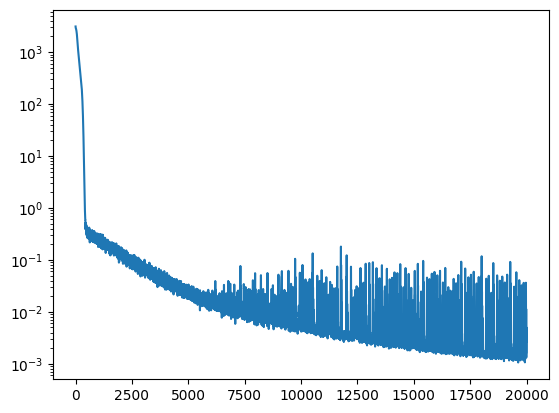

In [75]:
plt.semilogy(loss_list)

In [81]:
R0 = torch.zeros(1, requires_grad=True).to(device)
nn_sol_r0 = model(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_r0[[i]], range(4))
alphar = gradients(alpha, R0)

print("A_nn_r0 =",A.item())
print("A_r0    =",1)
print("")

print("alpha_nn_r0 =",alpha.item())
print("alpha_r0    >",0)
print("")

print("chi_nn_r0 =",chi.item())
print("chi_r0    =",0)
print("")

print("phi_nn_r0 =",phi.item())
print("phi0_r0   =",phi0.item())
print("")


print("alphar_nn_r0 =",alphar.item())
print("alphar_r0    =",0)

A_nn_r0 = 1.000136137008667
A_r0    = 1

alpha_nn_r0 = 0.8288607001304626
alpha_r0    > 0

chi_nn_r0 = 1.1203810572624207e-06
chi_r0    = 0

phi_nn_r0 = 0.015812717378139496
phi0_r0   = 0.015754399821162224

alphar_nn_r0 = 0.0003004521131515503
alphar_r0    = 0


In [83]:
rmax = RMAX*torch.ones(1, requires_grad=True).to(device)
nn_sol_rmax = model(rmax)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_rmax[[i]], range(4))
alphar = gradients(alpha, rmax)

print("A_nn_rmax =",A.item())
print("A_rmax    =",1)
print("")

print("alpha_nn_rmax =",alpha.item())
print("alpha_rmax    =",1)
print("")

print("chi_nn_rmax =",chi.item())
print("chi_rmax    =",0)
print("")

print("phi_nn_rmax =",phi.item())
print("phi0_rmax   =",0)

A_nn_rmax = 1.0005604028701782
A_rmax    = 1

alpha_nn_rmax = 1.000437617301941
alpha_rmax    = 1

chi_nn_rmax = -3.427732735872269e-05
chi_rmax    = 0

phi_nn_rmax = 5.2349409088492393e-05
phi0_rmax   = 0


In [84]:
#plt.plot(omegas)

In [85]:
# the time domain; used to visualize the analytical solution
N = 1000
R = torch.linspace(0,RMAX,N)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
RR = torch.linspace(0,RMAX,N).view(-1,1).to(device)

nn_sol = model(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A_nn, alpha_nn, chi_nn, phi_nn = map(lambda i:  nn_sol[:,[i]], range(4))


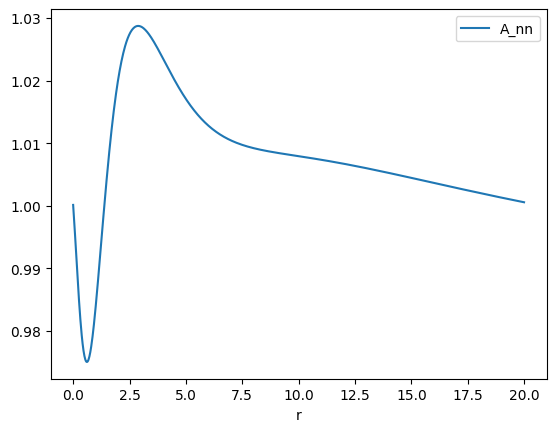

In [86]:
plt.plot(R, A_nn, label="A_nn")
plt.xlabel("r")
plt.legend()

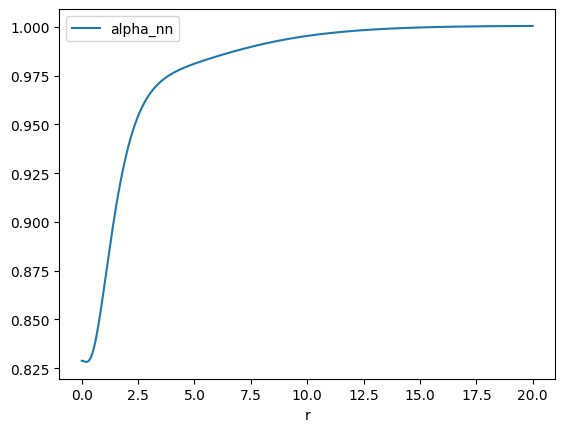

In [87]:
plt.plot(R, alpha_nn, label="alpha_nn")
plt.xlabel("r")
plt.legend()

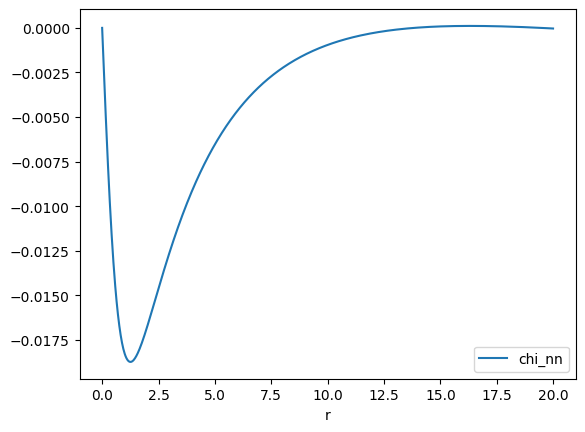

In [88]:
plt.plot(R, chi_nn, label="chi_nn")

plt.xlabel("r")
plt.legend()

[0.01581276]


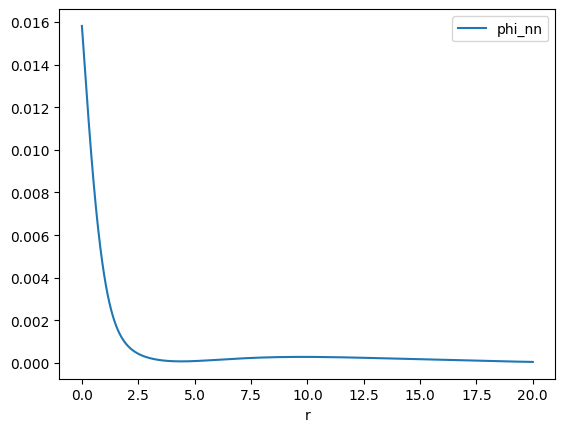

In [91]:
plt.plot(R, phi_nn, label="phi_nn")
print(phi_nn[0])
plt.xlabel("r")
#plt.ylim(0,0.002)
plt.legend()